In [1]:
import sys
sys.path.insert(0, "../source/")
sys.path.insert(0, "../models/AdvectionDiffusion_FEniCS")

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

from InverseProblem import InverseProblem
from FOM_stationary import FOM_stationary as FOM
from OEDUtility import OEDUtility

from MyDronePointEval import MyDronePointEval as DronePointEval
from MyDroneUniformEval import MyDroneUniformEval as DroneUniformEval
from MyDroneTruncGaussianEval import MyDroneTruncGaussianEval as DroneTruncGaussianEval
from MyDroneGaussianEval import MyDroneGaussianEval as DroneGaussianEval

import time
tStart_notebook = time.time()

import fenics as dl

import scipy.sparse as sparse
import scipy.sparse.linalg as sla

In [2]:
n_para = 5
var_prior = 1 # set to a high value (1e+6) to test convergence in noise-free situations

n_test = 40 # resolution for 1D plots
n_test_2d = 60 # resolution for 2D plots (50: ~1 min runtime for dt = 0.01)

sigma = 0.05
radius = 0.07

meshDim = 50
meshDim_drone = 10

bool_skip_2D_plots = True

In [3]:
tStart = time.time()
fom = FOM(meshDim = meshDim)
print("Runtime of this block: {} s".format(time.time()-tStart))

# compute one solution for nicer visualization below
#para_true = np.ones((n_para,))
para_true = np.zeros((n_para,))
para_true[0] = 1
state = fom.solve(parameter=para_true)

Runtime of this block: 1.606942892074585 s


In [4]:
#     grad_1 = f'exp(-0.5 * ((x[0]-0)*((x[0]-0)) + (x[1]-0)*(x[1]-0)) / {4 * t * sigma**2}) * (-x[0]/({2 * t * sigma ** 2}))'
#     grad_2 = f'exp(-0.5 * ((x[0]-0)*((x[0]-0)) + (x[1]-0)*(x[1]-0)) / {4 * t * sigma**2}) * (-x[1]/({2 * t * sigma ** 2}))'
#     grad_1 = dl.Expression(grad_1, degree=1)
#     grad_2 = dl.Expression(grad_2, degree=1)
 #grad_Phi = dl.as_vector((grad_1, grad_2))

In [5]:
tStart = time.time()

# set diffusion coefficient to be the variance we want
diffusion = sigma ** 2

# choose the final time to bring the coefficient 1/(4*pi*D*t) into the form 1/(2*pi*sigma**2)
t_final = 0.5

# specify time discretization for heat equation
dt = 0.01
n_steps = int(t_final / dt)
# todo: evaluate how fine the time discretization actually needs to be

# initialize variables
u_old = state.state  # last time step
# note: I've double-checked that this initialization will not cause state.state to be changed by the code below
# (Nicole, Nov 21, 2023)

n = dl.FacetNormal(fom.mesh)
x = dl.SpatialCoordinate(fom.mesh)

for k in range(n_steps):
    u = dl.TrialFunction(fom.V)
    v = dl.TestFunction(fom.V)
    w = dl.Function(fom.V)

    t = (k+1) * dt

    tStart_sub = time.time()
    Phi = dl.exp(-((x[0]-0)*((x[0]-0)) + (x[1]-0)*(x[1]-0)) / (4 * t * sigma**2))
    
    grad_1 = -Phi * x[0] / (2 * t * sigma**2)
    grad_2 = -Phi * x[1] / (2 * t * sigma**2)
    grad_Phi = dl.as_vector((grad_1, grad_2))
    
    #g = dt * dl.inner(dl.inner(grad_Phi, n), v) * dl.ds + dl.inner(u_old, v) * dl.dx
#     g = dl.inner(dl.inner(dl.grad(Phi), n), v) * dl.ds + dl.inner(u_old, v) * dl.dx
    g = dl.inner(u_old, v) * dl.dx
    print("setup:", time.time()-tStart_sub)
    
    # Define variational form for the heat equation, implicit Euler
    F = dl.inner(u, v) * dl.dx \
        + dl.Constant(dt * diffusion) * dl.inner(dl.nabla_grad(u), dl.nabla_grad(v)) * dl.dx 

    # solve for next time step
    tStart_sub = time.time()
    problem = dl.LinearVariationalProblem(F, g, w)
    solver = dl.LinearVariationalSolver(problem)
    solver.solve()

    print("solve:", time.time()-tStart_sub)
    
    # we don't actually need to remember the whole trajectory, only the final state
    u_old = w
    
print("Runtime of this block: ", (time.time()-tStart)/60, "min.") 

setup: 0.0005879402160644531
solve: 0.028855085372924805
setup: 0.0005691051483154297
solve: 0.03299832344055176
setup: 0.0006642341613769531
solve: 0.027524948120117188
setup: 0.0005011558532714844
solve: 0.025336027145385742
setup: 0.0004782676696777344
solve: 0.024852991104125977
setup: 0.0006120204925537109
solve: 0.024897098541259766
setup: 0.00045013427734375
solve: 0.02414107322692871
setup: 0.0004658699035644531
solve: 0.02568507194519043
setup: 0.0005040168762207031
solve: 0.025857210159301758
setup: 0.0005311965942382812
solve: 0.02487325668334961
setup: 0.0004849433898925781
solve: 0.025577306747436523
setup: 0.0004799365997314453
solve: 0.025881052017211914
setup: 0.0005388259887695312
solve: 0.026719331741333008
setup: 0.0005459785461425781
solve: 0.025168895721435547
setup: 0.00048470497131347656
solve: 0.024284839630126953
setup: 0.0004818439483642578
solve: 0.024820327758789062
setup: 0.0004749298095703125
solve: 0.02411484718322754
setup: 0.00044536590576171875
solve: 

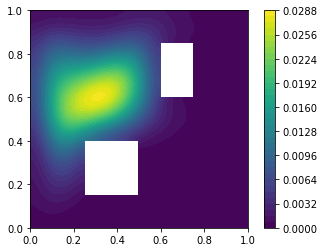

In [6]:
fom.plot(u_old)

In [7]:
merk = u_old.copy()

Putting it into matrix-vector form to speed up computations:

In [8]:
tStart = time.time()

# set diffusion coefficient to be the variance we want
diffusion = sigma ** 2

# choose the final time to bring the coefficient 1/(4*pi*D*t) into the form 1/(2*pi*sigma**2)
t_final = 0.5

# specify time discretization for heat equation
dt = 0.01
n_steps = int(t_final / dt)
# todo: evaluate how fine the time discretization actually needs to be

# initialize variables
u_old = state.state  # last time step
u_old = u_old.vector().vec().array

n = dl.FacetNormal(fom.mesh)
y = fom.mesh.coordinates()
y = y[dl.dof_to_vertex_map(fom.V), :]

# precompute matrices for faster solve
u = dl.TrialFunction(fom.V)
v = dl.TestFunction(fom.V)
w = dl.Function(fom.V)

# variational form for the heat equation, implicit Euler
F = dl.inner(u, v) * dl.dx \
        + dl.Constant(dt * diffusion) * dl.inner(dl.nabla_grad(u), dl.nabla_grad(v)) * dl.dx 
A = dl.assemble(F)
A = dl.as_backend_type(A).mat()  # PETSc matrix
A = sparse.csr_matrix(A.getValuesCSR()[::-1], shape=A.size)
LU_solver = sparse.linalg.splu(sparse.csc_matrix(A))

# mass matrix
m = dl.inner(u, v) * dl.dx
M = dl.assemble(m)
M = dl.as_backend_type(M).mat()  # PETSc matrix
M = sparse.csr_matrix(M.getValuesCSR()[::-1], shape=M.size)

# Neumann boundary condition
g0 = dl.inner(dl.inner(u, n[0]), v) * dl.ds
g1 = dl.inner(dl.inner(u, n[1]), v) * dl.ds

G0 = dl.assemble(g0)
G0 = dl.as_backend_type(G0).mat()  # PETSc matrix
G0 = sparse.csr_matrix(G0.getValuesCSR()[::-1], shape=G0.size)

G1 = dl.assemble(g1)
G1 = dl.as_backend_type(G1).mat()  # PETSc matrix
G1 = sparse.csr_matrix(G1.getValuesCSR()[::-1], shape=G1.size)

for k in range(n_steps):
    
    # the Neumann bouncary conditions change in each time step
    t = (k+1) * dt

    tStart_sub = time.time()
    
#     phi = np.exp(-((y[:, 0]-0)*((y[:, 0]-0)) + (y[:, 1]-0)*(y[:, 1]-0)) / (4 * t * sigma**2))
#     # todo: is there / np.sqrt(4*np.pi*sigma**2*t) missing here?
#     grad_0 = -phi * y[:, 0] / (2 * t * sigma**2)
#     grad_1 = -phi * y[:, 1] / (2 * t * sigma**2)
    
#     # compute rhs
#     rhs = dt * G0 @ grad_0 + dt * G1 @ grad_1 + M @ u_old
    rhs = M @ u_old

    # solve for next time step
    tStart_sub = time.time()
    
    #w = sparse.linalg.spsolve(A, rhs)
    w = LU_solver.solve(rhs)
    print("solve:", time.time()-tStart_sub)
    # todo: use LU decomposition for more efficiency
    
    # we don't actually need to remember the whole trajectory, only the final state
    u_old = w
    
print("Runtime of this block: ", (time.time()-tStart)/60, "min.") 

solve: 0.00067901611328125
solve: 0.0006260871887207031
solve: 0.0005319118499755859
solve: 0.0006148815155029297
solve: 0.0005619525909423828
solve: 0.0006470680236816406
solve: 0.0005619525909423828
solve: 0.0005352497100830078
solve: 0.0005590915679931641
solve: 0.0004990100860595703
solve: 0.0004837512969970703
solve: 0.0005779266357421875
solve: 0.00047898292541503906
solve: 0.0004248619079589844
solve: 0.000492095947265625
solve: 0.0005919933319091797
solve: 0.00043392181396484375
solve: 0.0004458427429199219
solve: 0.0004432201385498047
solve: 0.000438690185546875
solve: 0.0004417896270751953
solve: 0.00043702125549316406
solve: 0.0004451274871826172
solve: 0.0004379749298095703
solve: 0.0004420280456542969
solve: 0.00047469139099121094
solve: 0.00044798851013183594
solve: 0.00043892860412597656
solve: 0.0004930496215820312
solve: 0.0005710124969482422
solve: 0.0005178451538085938
solve: 0.0004982948303222656
solve: 0.0005168914794921875
solve: 0.0005428791046142578
solve: 0.000

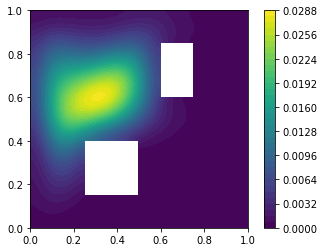

In [9]:
test = dl.Function(fom.V)
test.vector().vec().array = u_old

fom.plot(test)

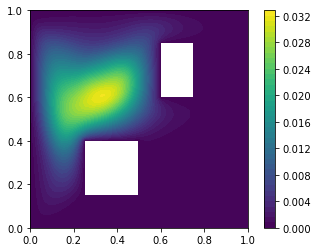

In [10]:
fom.plot(state.state)

In [11]:
diff = merk.vector().vec().array - u_old

In [12]:
diff

array([1.99899776e-19, 1.91429446e-19, 2.04981973e-19, ...,
       1.30104261e-17, 1.34441069e-17, 1.31188463e-17])

In [13]:
la.norm(diff, ord = np.infty)

5.100087019371813e-16

**Welcome back!**
Next steps:
- check that the computed convolution is indeed correct
- why are there negative values???

In [14]:
F = dl.inner(u, v) * dl.dx \
        + dl.Constant(dt * diffusion) * dl.inner(dl.nabla_grad(u), dl.nabla_grad(v)) * dl.dx 
A = dl.assemble(F)
A = dl.as_backend_type(A).mat()  # PETSc matrix

In [15]:
help(A)

Help on Mat object:

class Mat(Object)
 |  Method resolution order:
 |      Mat
 |      Object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  PtAP(...)
 |      Mat.PtAP(self, Mat P, Mat result=None, fill=None)
 |  
 |  SOR(...)
 |      Mat.SOR(self, Vec b, Vec x, omega=1.0, sortype=None, shift=0.0, its=1, lits=1)
 |  
 |  __add__(self, value, /)
 |      Return self+value.
 |  
 |  __call__(self, /, *args, **kwargs)
 |      Call self as a function.
 |  
 |  __delitem__(self, key, /)
 |      Delete self[key].
 |  
 |  __getitem__(self, key, /)
 |      Return self[key].
 |  
 |  __iadd__(self, value, /)
 |      Return self+=value.
 |  
 |  __imul__(self, value, /)
 |      Return self*=value.
 |  
 |  __isub__(self, value, /)
 |      Return self-=value.
 |  
 |  __itruediv__(self, value, /)
 |      Return self/=value.
 |  
 |  __mul__(self, value, /)
 |      Return self*value.
 |  
 |  __neg__(self, /)
 |      -self
 |  
 |  __pos__(self, /)
 |      +self
 |  
 |  __radd__